In [1]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from pandas import read_csv, read_feather
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as co
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time


DAY_CGS = u.day
M_SUN_CGS = co.M_sun
C_CGS = co.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * co.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * co.h * co.c ** 2 * np.pi) * u.Angstrom
X_CONST = (co.h * co.c / co.k_B)

In [2]:
class ArnettSource(sncosmo.Source):

    _param_names = ['texp', 'mej', 'fni', 'vej']
    param_names = ['texp', 'mej', 'fni', 'vej']

    param_names_latex = ['t_{exp}', 'M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, redshift,  params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._z = redshift
        # self._texp = texp
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * co.h * co.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (co.h * co.c / (wavelength * co.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, redshift, theta):
        texp, mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        mni = mej * fni
        # Convert velocity to cm/s
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g        
        texp = texp * u.day

        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
        # print(mej.to(u.Msun), vej, td)
        # if td < 3. * u.day:
        #     td = 3. * u.day
        # print(td)

        # use a denser time array for better integration
        t_to_integrate = np.linspace(0, np.max(t - texp), 1000)
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        
        spline = CubicSpline(t_to_integrate, dense_luminosities, extrapolate = False)
        luminosities = spline(t - texp) * u.erg / u.s # interpolate back from dense time array to original time points

        #Do BB calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)

        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        gind = (temperature < tfloor) | np.isnan(temperature)
        temperature = np.nan_to_num(temperature)
        notgind = np.invert(gind)
        temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)
        
        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        # fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density
        
        fluxes = self._blackbody_flux(temperature, radius, wvs / (1 + redshift)) # this is a luminosity density

        fluxes[t < texp,:] = 0.* u.kg *u.m / u.s**3
        fluxes[t < 0,:] = 0.* u.kg *u.m / u.s**3


        
        # divide luminosity density by 4pir^2 to get flux
        z = redshift * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density / (1 + redshift)


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._z, self._parameters)

In [3]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

# zeropoints from https://smtn-002.lsst.io/
zeropoints = [28.51, 28.36, 28.17, 27.78]
# LSST sky brightness in mag/arcsec^2 (from SMTN-002 official values)
sky_brightness_mag = [22.25, 21.2, 20.46, 19.61]  # g, r, i, z bands

# LSST observing parameters (from official LSST specs)
exptime = 30.0  # seconds per visit (2x15s exposures)
pixel_scale = 0.2  # arcseconds per pixel (LSST camera)
aperture_radius = 1.0  # arcseconds (typical PSF aperture, will be calculated properly)
read_noise = 8.8  # electrons per pixel per exposure
dark_current = 0.2  # electrons per pixel per second
num_bands = len(bands)

# Convert sky brightness to sky noise (electrons/pixel/second)
# Using LSST effective area = 6.423m diameter, pixel scale = 0.2 arcsec/pixel
# Sky noise = sky_flux * effective_area * pixel_area / exposure_time
# For now, using approximate values - these should be calculated more precisely
sky_noise = 10**(-0.4*(np.asarray(sky_brightness_mag) - np.asarray(zeropoints))) * pixel_scale**2  # g, r, i, z bands (electrons/pixel/second)


ia_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})

ibc_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})



In [6]:
def fit_ibc(true_z, lcs):

    arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 3, 0.05, 15000]) # initial parameter values? not sure why these are needed...
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[ mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)

    try:
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                          bounds={'texp':(-5,  30), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                         minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    except:
        print("Trying again...")
        arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 0.5, 0.1, 20000]) # initial parameter values? not sure why these are needed...
        arnett_model = sncosmo.Model(source=arnett_source)
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                  bounds={'texp':(0, 14), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                 minsnr = 5.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [7]:
def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

In [8]:
def fit_ia(true_z, lcs):    
    ia_source = sncosmo.get_source('salt2-extended', version='2.0')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

<ErrorbarContainer object of 3 artists>

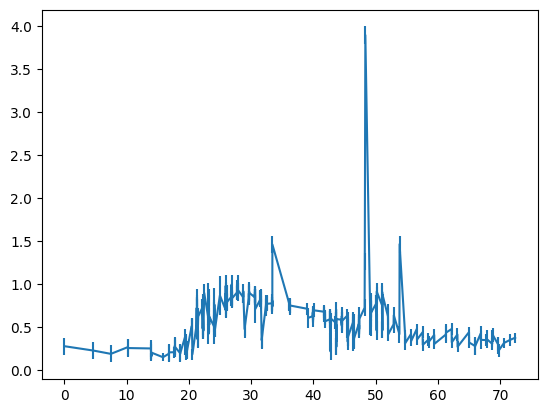

In [9]:
from astropy.table import Table
import pyarrow.feather as feather

# Read the feather file as a pyarrow Table
# Read the feather file as a pyarrow Table and convert to astropy Table
lc_table = feather.read_table("_ts.feather")

# print(lc_table.schema)

def ns_to_days(ns):
    return ns / (1e9 * 60 * 60 * 24)

def read_feather_file(filename):

    lc_table = feather.read_table(filename)


    # Convert each column to a numpy array and print its name and shape
    columns = {}
    for col_name in ['phase', 'mag', 'mag_error', 'flux', 'flux_error', 'filter', 'zeropoint']:
        arr = np.array(lc_table[col_name])
        # print(f"{col_name}: shape {arr.shape}")
        # Replace NaNs with zero if the dtype is float
        if np.issubdtype(arr.dtype, np.floating):
            arr = np.nan_to_num(arr, nan=0.1)
        columns[col_name] = arr

    columns['time'] = columns['phase'] - np.min(columns['phase'])
    # columns['time'] = columns['phase']

    columns['zpsys'] = np.array(['ab'] * len(columns['phase']), dtype=str)

    band_name_dict = {'ZTF_r': 'ztfr', 'ZTF_g': 'ztfg', 'ZTF_i': 'ztfi'}

    columns['band'] = np.array([band_name_dict[i] for i in columns['filter']], dtype=str)

    # remove unit from time and convert to days, then to float64
    # If the dtype is timedelta64[ns], convert to float days
    if np.issubdtype(columns['time'].dtype, np.timedelta64):
        columns['time'] = columns['time'].astype('timedelta64[ns]').astype('float64') / (1e9 * 60 * 60 * 24)
    columns['time'] = columns['time'].astype(np.float64)

    # Remove the 'phase' column
    del columns['phase']
    del columns['filter']


    # Create an astropy Table from these columns
    astropy_lc_table = Table(columns)
    # print(astropy_lc_table)
    return astropy_lc_table

astropy_lc_table = read_feather_file("_ts.feather")

plt.errorbar(astropy_lc_table['time'], astropy_lc_table['flux'], yerr = astropy_lc_table['flux_error'])


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


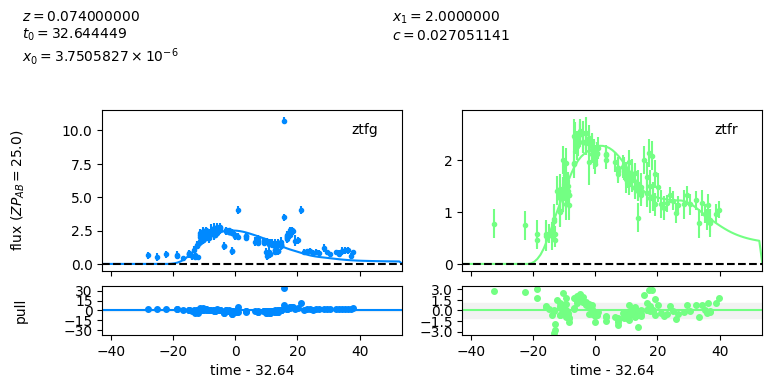

In [10]:
result, fitted_model = fit_ia(0.074, [astropy_lc_table])
sncosmo.plot_lc(astropy_lc_table, model=fitted_model);

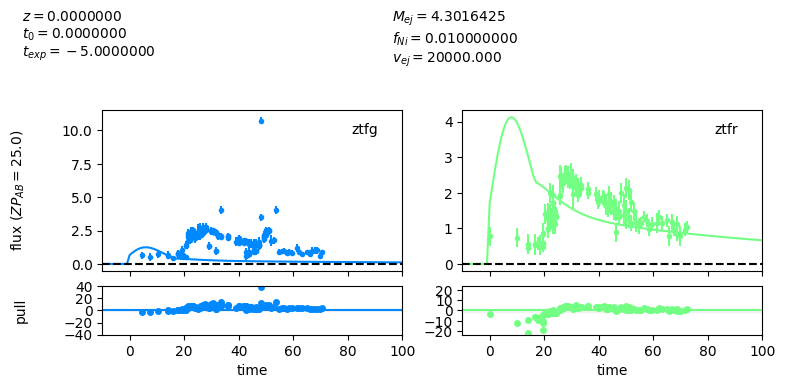

In [11]:
result, fitted_model = fit_ibc(0.074, [astropy_lc_table])
sncosmo.plot_lc(astropy_lc_table, model=fitted_model);

In [12]:
import dill

dill_path = "meta.dill copy"


def read_meta_file(dill_path):
    # Replace with your actual file path
    with open(dill_path, "rb") as f:
        obj = dill.load(f)

    # print(type(obj))
    # print(obj.keys())

    return obj['spec_class'], obj['redshift']

In [13]:
from os import walk

f = []
d = []
for (dirpath, dirnames, filenames) in walk("transients_spec_group/"):
    f.extend(filenames)
    d.extend(dirnames)
    break


In [14]:
lcs = []
types = []
redshifts = []
for i in range(len(d)):
    # print(d[i])
    lc = read_feather_file("transients_spec_group/" + d[i] + "/_photometry/_ts.feather")
    sn_type, redshift = read_meta_file("transients_spec_group/" + d[i] + "/meta.dill")
    # print(sn_type, redshift)
    types.append(sn_type)
    lcs.append(lc)
    redshifts.append(redshift)

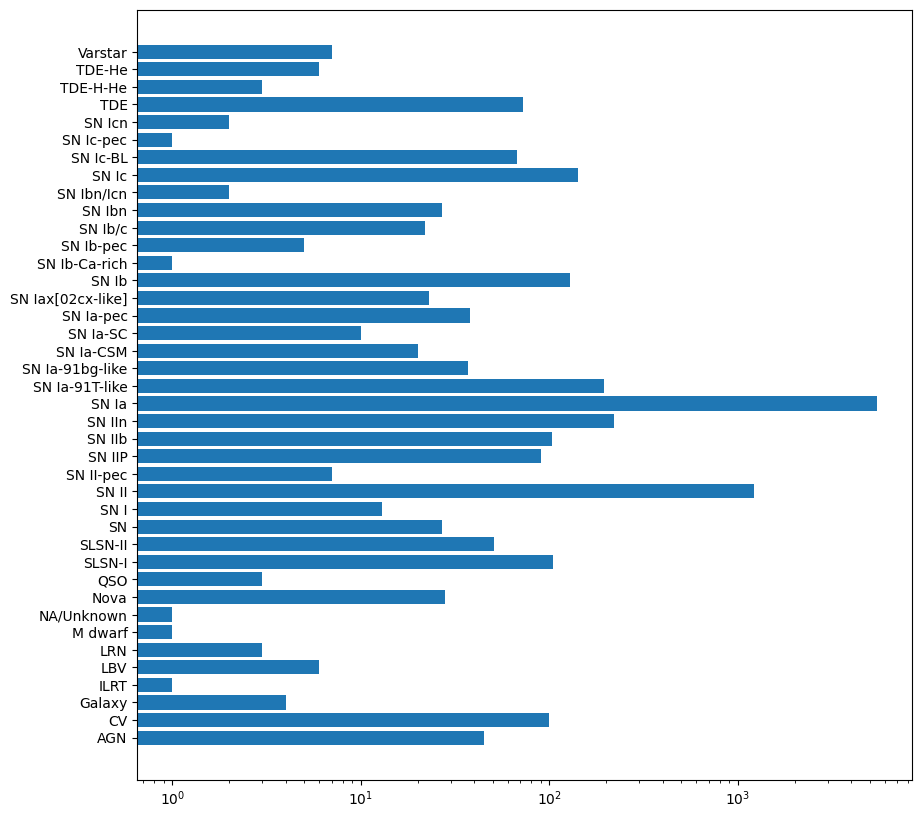

In [15]:
fig = plt.figure(figsize=(10,10))

unique_types, counts = np.unique(types, return_counts=True)

plt.barh(unique_types, counts)
plt.xscale('log')

In [16]:
acceptable_types = ['SN Ia', 'SN Ib/c', "SN Ic-BL", "SN Ic", "SN Ib"]
acceptable_indexes = [i for i in range(len(types)) if types[i] in acceptable_types]
[counts[i] for i in [list(unique_types).index(t) for t in acceptable_types]]

[5467, 22, 67, 142, 129]

In [17]:
len(acceptable_indexes)

5827

In [18]:
class real_SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_redshift):
        self.true_class = true_class
        self.true_redshift = true_redshift
        # if self.true_class == 'ia':
        #     self.true_params = {key:true_dict[key] for key in self.ia_keys}
        # elif self.true_class == 'ibc':
        #     self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        # else:
        #     raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}

In [ ]:
sn_objects = []
for i in np.random.choice(acceptable_indexes, size=300):
    try:
        ia_result, ia_fitted_model = fit_ia(redshifts[i], [lcs[i]])
        ibc_result, ibc_fitted_model = fit_ibc(redshifts[i], [lcs[i]])
        sn_obj = real_SN(types[i], redshifts[i])
        sn_obj.fit_as_ia(sncosmo.flatten_result(ia_result))
        sn_obj.fit_as_ibc(sncosmo.flatten_result(ibc_result))
        sn_objects.append(sn_obj)
    except Exception as e:
        print(f"Exception for index {i}: {e}")
    


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
Exception for index 4954: `y` must contain only finite values.
Trying again...
Exception for index 5365: `y` must contain only finite values.
Trying again...
Exception for index 4407: `y` must contain only finite values.


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:377: RuntimeWarning: overflow encountered in add
  res = np.cumsum(d * (y[slice1] + y[slice2]) / 2.0, axis=axis)


Trying again...
Trying again...
Exception for index 2554: `y` must contain only finite values.
Trying again...
Exception for index 2145: `y` must contain only finite values.
Trying again...
Exception for index 7354: `y` must contain only finite values.
Trying again...
Exception for index 5571: `y` must contain only finite values.
Trying again...
Exception for index 3903: `y` must contain only finite values.
Trying again...
Exception for index 6014: `y` must contain only finite values.
Trying again...
Trying again...
Trying again...
Exception for index 2756: `y` must contain only finite values.
Trying again...
Trying again...
Trying again...
Exception for index 3751: `y` must contain only finite values.
Trying again...
Exception for index 1743: `y` must contain only finite values.
Trying again...
Exception for index 1235: `y` must contain only finite values.
Trying again...
Trying again...
Exception for index 1671: `y` must contain only finite values.
Trying again...
Trying again...
Exc

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Exception for index 5232: `y` must contain only finite values.
Trying again...
Trying again...
Trying again...
Exception for index 7821: `y` must contain only finite values.
Trying again...
Exception for index 729: `y` must contain only finite values.
Trying again...
Trying again...
Exception for index 2312: `y` must contain only finite values.
Trying again...
Exception for index 4401: `y` must contain only finite values.


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in add
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
Exception for index 4126: `y` must contain only finite values.
Trying again...
Exception for index 4109: `y` must contain only finite values.
Trying again...
Exception for index 1735: `y` must contain only finite values.
Trying again...
Trying again...


In [ ]:
len(sn_objects)

121

In [ ]:
sn_objects[1].ia_fit, sn_objects[1].ibc_fit, sn_objects[1].true_redshift, sn_objects[1].true_class

({'t0': 10.502749206159644,
  'x0': 3.803449917730463e-06,
  'x1': 1.7817900612090791,
  'c': 0.11738536386278998},
 {'texp': -6.9200613521690695,
  'mej': 0.4829261219174688,
  'fni': 0.018795192722473982,
  'vej': 2000.0000363719412},
 0.056,
 'SN Ia')

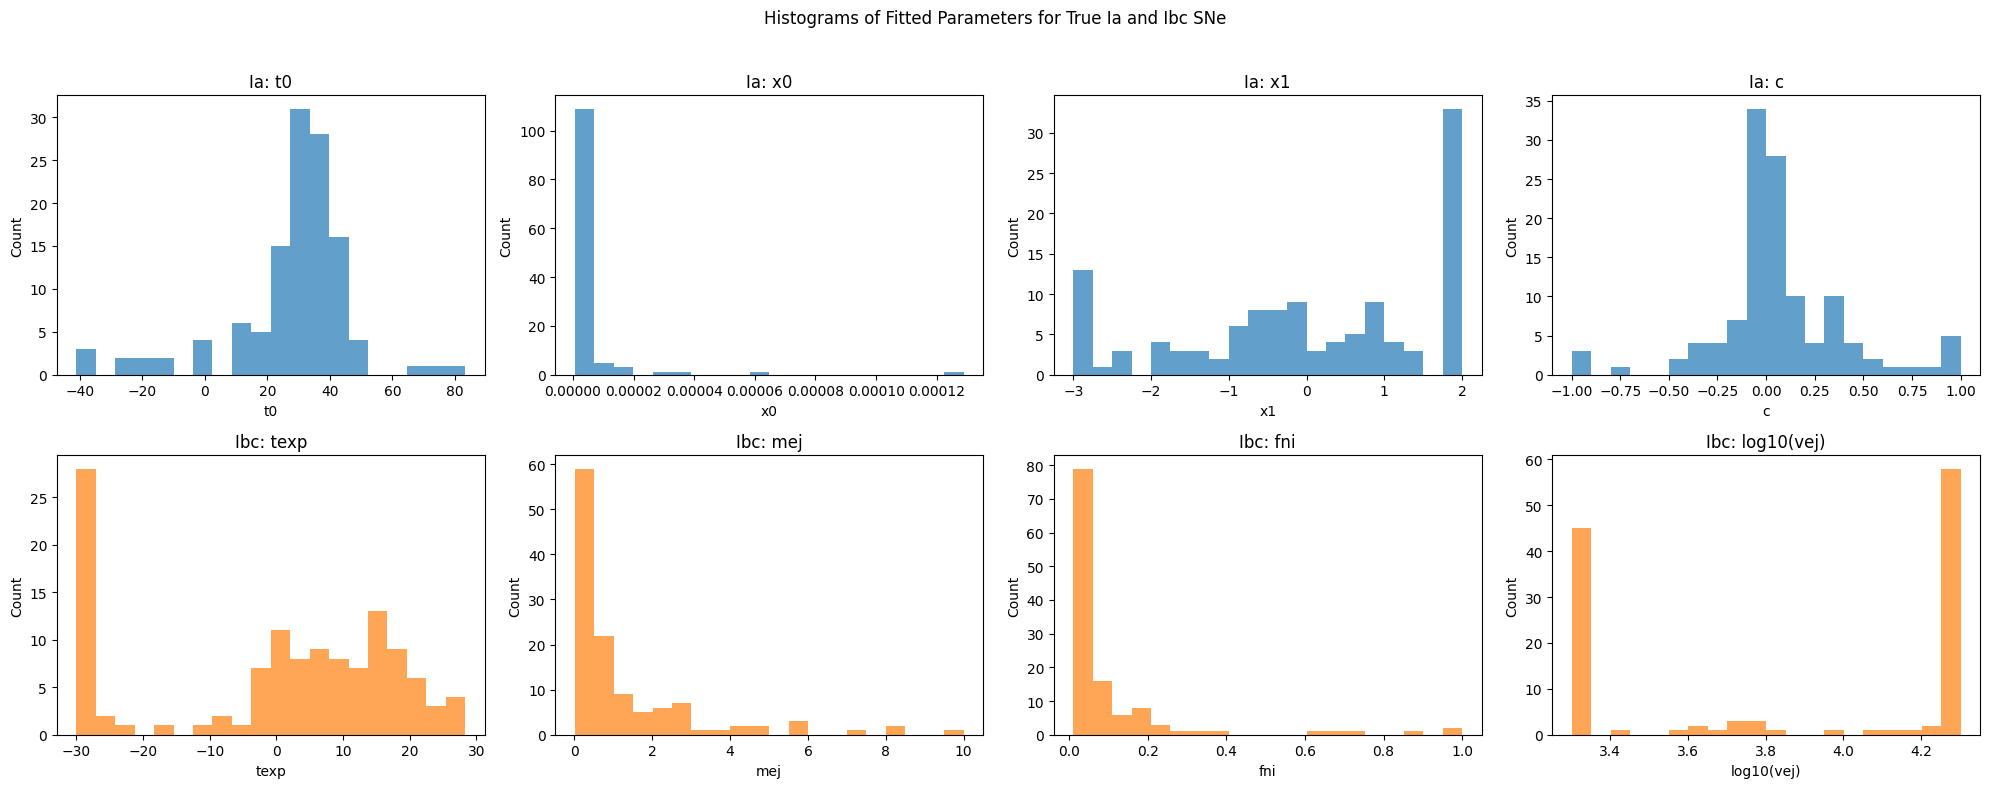

In [ ]:
ia_param_names = sn_objects[1].ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = sn_objects[1].ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

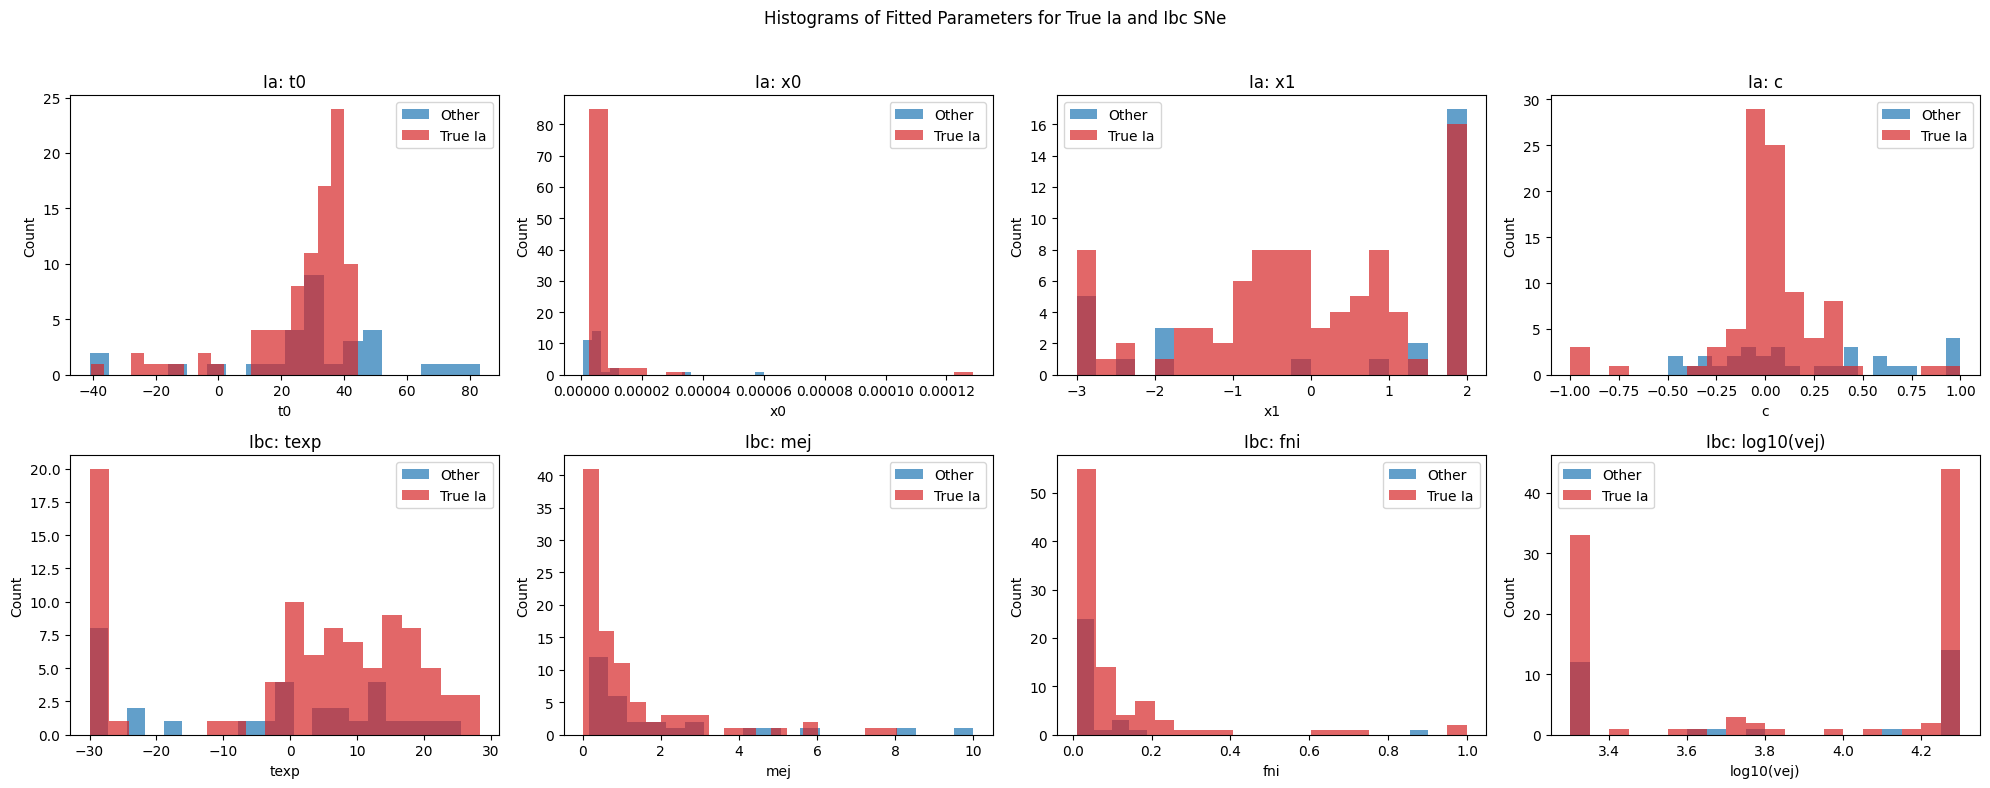

In [ ]:
ia_param_names = sn_objects[1].ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = sn_objects[1].ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values_ia = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None and sn.true_class == 'SN Ia']
    values_other = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None and sn.true_class != 'SN Ia']
    axes[0, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other')
    axes[0, i].hist(values_ia, bins=20, color='tab:red', alpha=0.7, label='True Ia')
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")
    axes[0, i].legend()

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values_ibc = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None and sn.true_class == 'SN Ia']
    values_other = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None and sn.true_class != 'SN Ia']
    if param == 'vej':
        values_other = [np.log10(v) for v in values_other if v > 0]
        values_ibc = [np.log10(v) for v in values_ibc if v > 0]
        axes[1, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other')
        axes[1, i].hist(values_ibc, bins=20, color='tab:red', alpha=0.7, label='True Ia')
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other')
        axes[1, i].hist(values_ibc, bins=20, color='tab:red', alpha=0.7, label='True Ia')
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")
    axes[1, i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
sum([sn.true_class == 'SN Ia' for sn in sn_objects])

91

In [ ]:
np.unique([sn.true_class for sn in sn_objects])

array(['AGN', 'SLSN-I', 'SN I', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn',
       'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ib', 'SN Ibn',
       'SN Ic', 'TDE'], dtype='<U15')